## Imports y data load

In [52]:
#imports

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Modelo multiclase

In [29]:
df_int_multiclase = pd.read_csv('../data/base_procesada_multiclase.csv')
df_int_multiclase.head()

,Estudios_máximos_antes_de_la_inscripción,estado_civil,sexo,desplazado,Asistencia_diurna/nocturna,Cualificación_promedio_de_estudios_previos,Puntaje_en_examen_de_ingreso,Necesidades_educativas_especiales,Tiene_deuda,Pago_de_matrícula_al_día,...,Carrera_Gestión,Carrera_Ingeniería Informática,Carrera_Periodismo y Comunicación,Carrera_Psicología,Carrera_Publicidad y Marketing,Carrera_Química,Carrera_Sociología,Carrera_Turismo,Carrera_Veterinaria,target_multiclase
0,3,1,0,0,1,66,65,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1,0,1,1,69,66,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,1,0,1,1,69,63,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,1,1,68,68,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3,1,1,1,1,68,70,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [30]:
X = df_int_multiclase.drop(columns=['target_multiclase'])
y = df_int_multiclase['target_multiclase']

In [31]:
#Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [32]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN

### Sin smote

k=2, Accuracy=0.7346
k=5, Accuracy=0.7546
k=7, Accuracy=0.7615
k=10, Accuracy=0.7646
k=12, Accuracy=0.7655
k=15, Accuracy=0.7667
k=20, Accuracy=0.7671


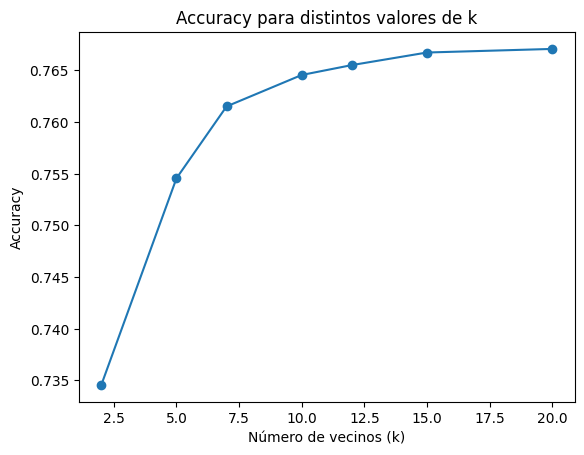

In [33]:
#Pruebo distintos valores de vecinos cercanos para ver cuál predice mejor
k_values = [2, 5, 7, 10, 12, 15, 20]

accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k={k}, Accuracy={acc:.4f}")

# Graficar resultados
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy para distintos valores de k")
plt.show()


In [34]:
#Uso el mejor valor de k-vecinos para armar el modelo
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy de la clasificación: {:.2f}%".format(accuracy * 100))

Accuracy de la clasificación: 76.15%


In [35]:
#Veo el reporte de la clasificación
print(classification_report(y_test, y_pred))

'''
Precisión: "cuando el modelo predice clase x, acierta el x% de las veces." VP / (VP+FP) De todas las veces que el modelo dijo que algo era positivo, ¿cuántas veces acertó?
Recall: "de todos los verdaderos clase x, el modelo detecta el x%." VP / (VP+FN) De todos los casos que realmente eran positivos, ¿cuántos identificó correctamente el modelo?
F1: promedio armónico entre precision y recall.

'''

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      7137
           1       0.60      0.55      0.58      2817
           2       0.69      0.34      0.46      1548

    accuracy                           0.76     11502
   macro avg       0.70      0.61      0.64     11502
weighted avg       0.75      0.76      0.74     11502



'\nPrecisión: "cuando el modelo predice clase x, acierta el x% de las veces." VP / (VP+FP) De todas las veces que el modelo dijo que algo era positivo, ¿cuántas veces acertó?\nRecall: "de todos los verdaderos clase x, el modelo detecta el x%." VP / (VP+FN) De todos los casos que realmente eran positivos, ¿cuántos identificó correctamente el modelo?\nF1: promedio armónico entre precision y recall.\n\n'

### Con smote

In [36]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

k=2, Accuracy=0.7079
k=5, Accuracy=0.6780
k=7, Accuracy=0.6808
k=10, Accuracy=0.6943
k=12, Accuracy=0.6943
k=15, Accuracy=0.6926
k=20, Accuracy=0.7006


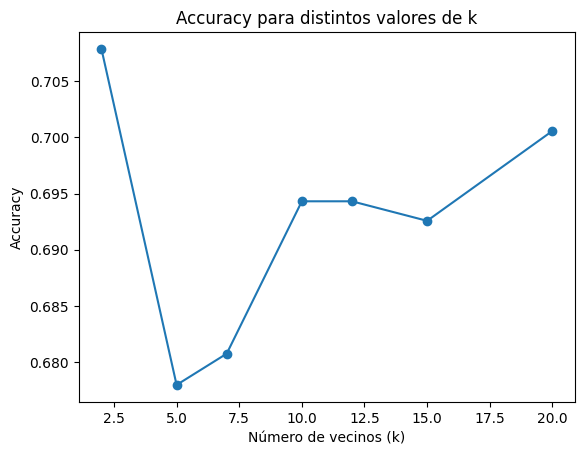

In [37]:
#Pruebo distintos valores de vecinos cercanos para ver cuál predice mejor
k_values = [2, 5, 7, 10, 12, 15, 20]

accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred_smote)
    accuracies.append(acc)
    print(f"k={k}, Accuracy={acc:.4f}")

# Graficar resultados
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy para distintos valores de k")
plt.show()

In [38]:
#Uso el mejor valor de k-vecinos para armar el modelo
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_smote)
print("Accuracy de la clasificación: {:.2f}%".format(accuracy * 100))

Accuracy de la clasificación: 70.79%


In [39]:
#Veo el reporte de la clasificación
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      7137
           1       0.52      0.49      0.50      2817
           2       0.47      0.43      0.45      1548

    accuracy                           0.71     11502
   macro avg       0.60      0.59      0.60     11502
weighted avg       0.70      0.71      0.70     11502



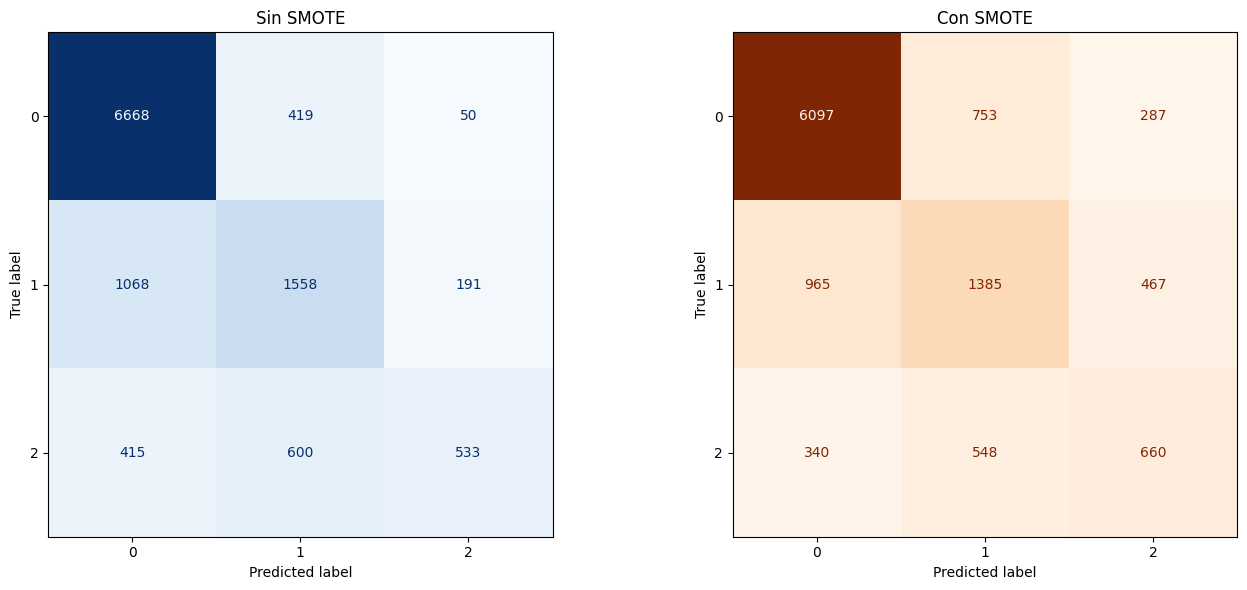

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz sin SMOTE
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Sin SMOTE")

# Matriz con SMOTE
cm_smote = confusion_matrix(y_test, y_pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=model.classes_)
disp_smote.plot(cmap=plt.cm.Oranges, ax=axes[1], colorbar=False)
axes[1].set_title("Con SMOTE")

plt.tight_layout()
plt.show()

In [41]:
'''' Con SMOTE predice mejor la clase 3, es decir a los graduados, pero se pierde precisión para predecir a las demás
Como el objetivo es predecir la clase 1, no tiene sentido utilizar esta estrategia '''

"' Con SMOTE predice mejor la clase 3, es decir a los graduados, pero se pierde precisión para predecir a las demás\nComo el objetivo es predecir la clase 1, no tiene sentido utilizar esta estrategia "

## Random Forest

In [42]:
#RF no necesita escalar datos. Realizao la búsqueda de hiperparámetros con método random
#En la búsqueda de hiperparámetros, penalizara más los errores en la clase minoritaria ('class_weight')
# Con esta estrategia, descarto realizar el SMOTE.  

parameters = {'n_estimators':range(10, 51, 10), 'max_depth': range(5, 10), 'bootstrap':[True, False], 'min_samples_leaf': [1, 5, 10, 50],
              'max_features':['sqrt', 'log2', None], 'class_weight': ['balanced', None]}
clf = RandomizedSearchCV(RandomForestClassifier(random_state=42), parameters, scoring='accuracy',cv=5, n_iter=50, random_state=42)

clf.fit(X_train, y_train)
rf = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

0.7827116090993105 {'n_estimators': 40, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 8, 'class_weight': None, 'bootstrap': True}
Accuracy training : 0.796
Accuracy test: 0.784


In [43]:
#RF final con los mejores HP encontrados
rf_final = RandomForestClassifier(**clf.best_params_, random_state=42)   # ** hace unpacking de diccionarios
rf_final.fit(X_train, y_train)

y_pred_final = rf_final.predict(X_test)


print("Accuracy training : {:.3f}".format(rf_final.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf_final.score(X_test, y_test)))

Accuracy training : 0.796
Accuracy test: 0.784


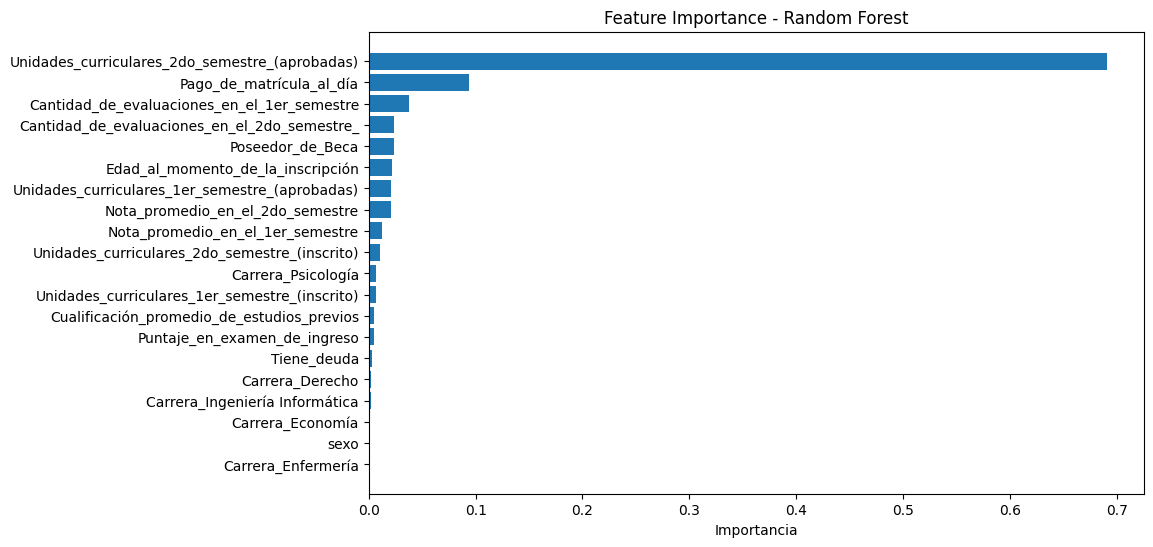

In [44]:
# Obtener la importancia de las features
importances = rf_final.feature_importances_
feature_names = X_train.columns 
feat_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances})

# Ordenar de mayor a menor
feat_importances = feat_importances.sort_values(by='importance', ascending=False).head(20)

# Graficar
plt.figure(figsize=(10,6))
plt.barh(feat_importances['feature'], feat_importances['importance'])
plt.gca().invert_yaxis()  # para que la más importante quede arriba
plt.xlabel('Importancia')
plt.title('Feature Importance - Random Forest')
plt.show()

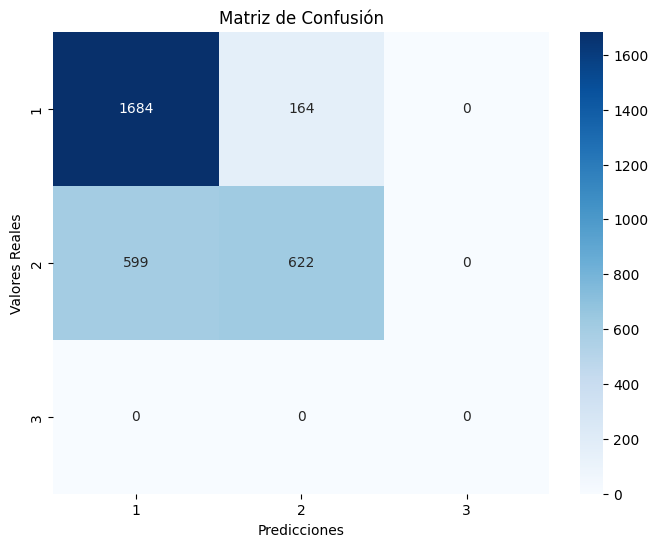

              precision    recall  f1-score   support

           1       0.63      0.60      0.61      2817
           2       0.77      0.40      0.53      1548
           3       0.00      0.00      0.00         0

   micro avg       0.66      0.53      0.59      4365
   macro avg       0.47      0.33      0.38      4365
weighted avg       0.68      0.53      0.58      4365



/Users/sofiaforni/Documents/FCEN UBA Maestria/aprendizaje automatico 2025/aprendizaje_automatico_desertores/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofiaforni/Documents/FCEN UBA Maestria/aprendizaje automatico 2025/aprendizaje_automatico_desertores/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofiaforni/Documents/FCEN UBA Maestria/aprendizaje automatico 2025/aprendizaje_automatico_desertores/venv/lib/python3.13/site-packages/sklearn/metrics/_cla

In [45]:
from sklearn.metrics import classification_report

# Definir las clases originales
clases = [1, 2, 3]  # tus clases reales
nombres = ['1', '2', '3']

cm = confusion_matrix(y_test, y_pred_final, labels=clases)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nombres, yticklabels=nombres)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print(classification_report(y_test, y_pred_final, labels=clases, target_names=nombres))

##  Boosting y Bagging

In [46]:
# modelo multiclase
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3, 
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbose=-1 
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluar
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7933
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7137
           1       0.64      0.62      0.63      2817
           2       0.75      0.44      0.56      1548

    accuracy                           0.79     11502
   macro avg       0.75      0.67      0.69     11502
weighted avg       0.79      0.79      0.78     11502



In [47]:
print(y_train)

36823    1
16549    0
16034    0
48615    0
38675    0
        ..
11868    0
33317    2
41860    0
9078     0
17783    1
Name: target_multiclase, Length: 46008, dtype: int64


In [48]:
X = df_int_multiclase.drop(['target_multiclase'], axis=1)
y = df_int_multiclase['target_multiclase']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [49]:
import xgboost as xgb

# Modelo XGBoost para multiclase
model = xgb.XGBClassifier(
    objective='multi:softmax',  
    num_class=3,                
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

# Entrenar
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

# Evaluar
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7938

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7137
           1       0.64      0.63      0.63      2817
           2       0.76      0.44      0.55      1548

    accuracy                           0.79     11502
   macro avg       0.75      0.67      0.69     11502
weighted avg       0.79      0.79      0.78     11502



In [50]:
# Definir modelo base
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42
)

# Definir grid de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # o 'f1_macro' para desbalanceo
    n_jobs=-1,  # usar todos los cores
    verbose=2
)

print("Iniciando Grid Search...")
grid_search.fit(X_train, y_train)

# Mejores parámetros
print("\n" + "="*50)
print("MEJORES PARÁMETROS:")
print("="*50)
print(grid_search.best_params_)
print(f"\nMejor Score CV: {grid_search.best_score_:.4f}")

# Mejor modelo
best_model = grid_search.best_estimator_

# Predecir con mejor modelo
y_pred = best_model.predict(X_test)

# Evaluar
print("\n" + "="*50)
print("RESULTADOS EN TEST:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Iniciando Grid Search...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, 

In [53]:
# Grid más pequeño para pruebas rápidas
param_grid_small = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1, 0.3],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [3, 5]
}

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(
        loss_function='MultiClass',
        random_seed=42,
        verbose=False
    ),
    param_grid=param_grid_small,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Predecir con mejor modelo
y_pred = grid_search.predict(X_test)

# Evaluar
print("\n" + "="*50)
print("RESULTADOS EN TEST:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/sofiaforni/Documents/FCEN UBA Maestria/aprendizaje automatico 2025/aprendizaje_automatico_desertores/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



RESULTADOS EN TEST:
Accuracy: 0.7935

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7137
           1       0.64      0.62      0.63      2817
           2       0.73      0.45      0.56      1548

    accuracy                           0.79     11502
   macro avg       0.74      0.67      0.69     11502
weighted avg       0.79      0.79      0.78     11502

